# softmax的从0开始实现
本节我们将使用刚刚引入的Fashion-MNIST数据集， 并设置数据迭代器的批量大小为256

In [1]:
import torch
import sys
sys.path.append("../")
sys.path.append("../../")
from MyUtils import d2laiUtils

batch_size = 256
train_iter, test_iter = d2laiUtils.loadFashionMnist(batch_size)

## 数据初始化
这里，对于每一个28x28的灰度图，输入即为所有的像素点，也即28x28=784个特征，需要展成一个向量1x784。输出是10个维度，代表10个种类。全连接网络的参数W是一个784x10的矩阵，偏置将构成一个1x10的行向量。我们将使用正态分布初始化我们的权重W，偏置初始化为0。

In [7]:
num_inputs = 28*28
num_outputs = 10
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

## 定义softmax操作
1. 对每个项求幂（使用exp）；
2. 对每一行求和（小批量中每个样本是一行），得到每个样本的规范化常数；
3. 将每一行除以其规范化常数，确保结果的和为1。

In [25]:
# X(batch_size, num_inputs) W(num_inputs, num_outputs) b(1, num_outputs)
# (XW+b)[batch_size, num_outputs]
def softmax(X):
    expX = torch.exp(X)
    eXsum = expX.sum(dim=1, keepdim=True) # 注意keepdim=True, 便于广播
    return expX/eXsum


In [26]:
# 定义soft回归模型
def net(X):
    return softmax(torch.matmul(X.reshape(-1, num_inputs), W)+b)

## 交叉熵损失函数Entropy
$$l(\mathbf{y}, \hat{\mathbf{y}}) = - \sum_{j=1}^q y_j \log \hat{y}_j.$$
以上是单个的样本损失函数，这里$\mathbf{y}$是经过独热编码后的标签向量, 例如若原标签值为3(假设共10个类), 表示对应样本应分为第三类, 经过编码后得到$\mathbf{y}$, 除了第3个位置为1, 其余位置为0. 因此这一求和实际简化为$-\log \hat{y}_3$


In [29]:
# 一个Tensor切片选择技巧
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
# 以上 y_hat 表示了在包含 3 个类别的训练问题中得到的 2 个样本的概率预测情况
# 而 y 表示了这两个样本真实标签是第 0 类 和 第2类

# 这一表达式选取了 第一个样本预测为第0类的概率以及第2个样本预测为第2类的概率
y_hat[[0, 1], y], y_hat[[0, 1], y].shape

(tensor([0.1000, 0.5000]), torch.Size([2]))

In [30]:
# 由此编写交叉熵损失函数
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y)), y])
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [50]:
# 编写一个精度计算函数
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(dim=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())
accuracy(y_hat, y)

1.0

In [51]:
# 继续封装, 计算一个模型在某一数据集上的精度
# 为此，先定义一个计数器
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [52]:
def evaluate_accuracy(net, data_iter):
    """计算模型在指定数据集上的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval() # 转为评估模式
    metric = Accumulator(2) # 分别记录 正确数 和 总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

evaluate_accuracy(net, test_iter)

0.0731

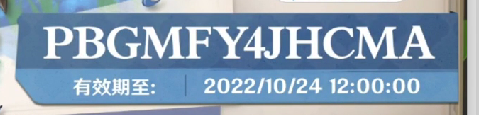

In [57]:
def train_epoch(net, train_iter, loss, updater):
    """进行一个周期的训练"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)    # 训练损失总和、训练准确数、样本总数
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用pytorch内置函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 自己定义的函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回 损失 和 精度
    return metric[0]/metric[2], metric[1]/metric[2]

在展示训练函数的实现之前，我们定义一个在动画中绘制数据的实用程序类Animator， 它能够简化本书其余部分的代码。

接下来我们实现一个训练函数， 它会在train_iter访问到的训练数据集上训练一个模型net。 该训练函数将会运行多个迭代周期（由num_epochs指定）。 在每个迭代周期结束时，利用test_iter访问到的测试数据集对模型进行评估。 我们将利用Animator类来可视化训练进度。
    

In [61]:
lr = 0.1
loss = cross_entropy
def updater(batch_size):
    return d2laiUtils.sgd([W, b], lr, batch_size)

num_epochs = 10
for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        print(f"in epoch {epoch+1}: "
              f"train-loss={train_metrics[0]:.3f}\t"
              f"train-acc={train_metrics[1]:.5f}\t"
             f"test-acc={test_acc:.5f}")


in epoch 1: train-loss=0.443	train-acc=0.84913	test-acc=0.82840
in epoch 2: train-loss=0.439	train-acc=0.85052	test-acc=0.82250
in epoch 3: train-loss=0.436	train-acc=0.85087	test-acc=0.83520
in epoch 4: train-loss=0.433	train-acc=0.85215	test-acc=0.83040
in epoch 5: train-loss=0.430	train-acc=0.85360	test-acc=0.83790
in epoch 6: train-loss=0.427	train-acc=0.85437	test-acc=0.83740
in epoch 7: train-loss=0.426	train-acc=0.85443	test-acc=0.83800
in epoch 8: train-loss=0.424	train-acc=0.85490	test-acc=0.83630
in epoch 9: train-loss=0.422	train-acc=0.85638	test-acc=0.83770
in epoch 10: train-loss=0.420	train-acc=0.85608	test-acc=0.83880


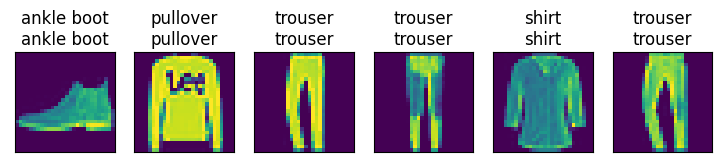

In [62]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2laiUtils.get_fashion_mnist_labels(y)
    preds = d2laiUtils.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2laiUtils.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)